# 逻辑回归 Logistic Regression

此Notebook是配合Andrew Ng "Machine Leanring"中[逻辑回归](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/logistic-regression.md)部分学习使用。

测试用python版本为3.6
* 机器学习路径：https://github.com/loveunk/machine-learning-deep-learning-notes/
* 内容正文综合参考网络资源，使用中如果有疑问请联络：www.kaikai.ai

在这一次练习中，我们将要实现逻辑回归并且应用到一个分类任务。我们还将通过将正则化加入训练算法，来提高算法的鲁棒性，并用更复杂的情形来测试它。


## 准备数据

在训练的初始阶段，我们将要构建一个逻辑回归模型来预测，某个学生是否被大学录取。设想你是大学相关部分的管理者，想通过申请学生两次测试的评分，来决定他们是否被录取。现在你拥有之前申请学生的可以用于训练逻辑回归的训练样本集。对于每一个训练样本，你有他们两次测试的评分和最后是被录取的结果。为了完成这个预测任务，我们准备构建一个可以基于两次测试评分来评估录取可能性的分类模型。

让我们从检查数据开始。

In [38]:
import numpy as np # type: ignore
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import classification_report # 这个包是评价报告

In [39]:
path = 'ex2data1.txt'
data = pd.read_csv(path, header=None, names=['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [40]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


让我们创建两个分数的散点图，并使用颜色编码来可视化，如果样本是正的（被接纳）或负的（未被接纳）。

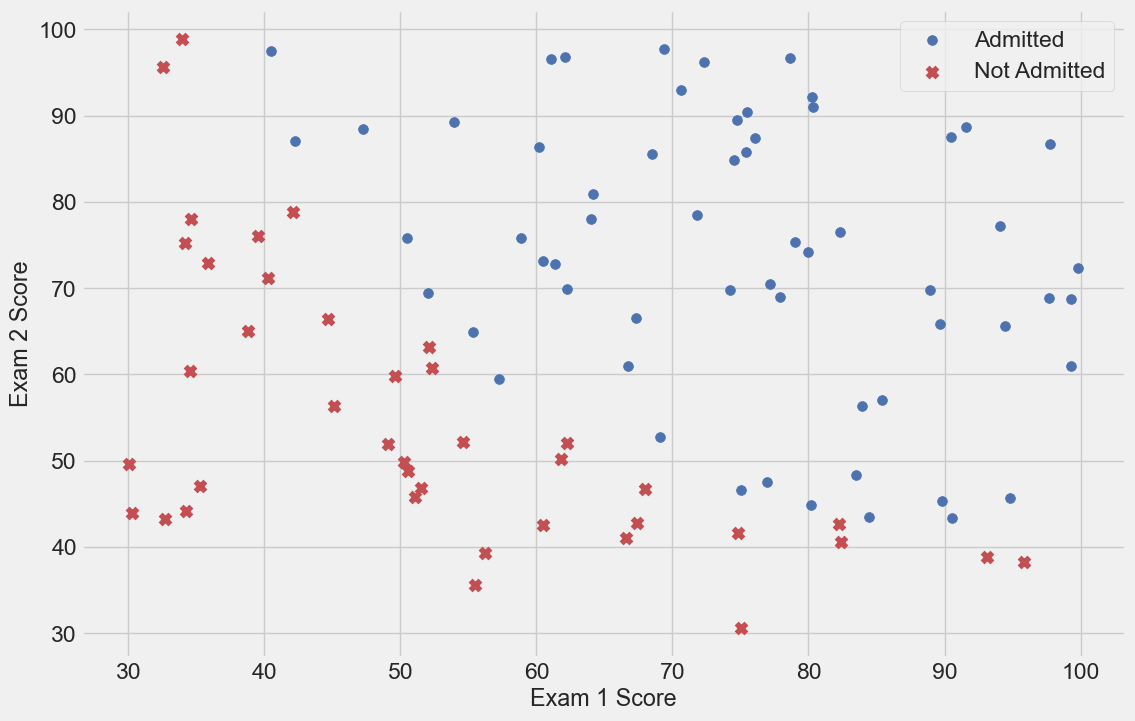

In [41]:
positive = data[data['admitted'].isin([1])]
negative = data[data['admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['exam1'], positive['exam2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

In [42]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].values  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [43]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


看起来在两类间，有一个清晰的决策边界。现在我们需要实现逻辑回归，那样就可以训练一个模型来预测结果。

## Sigmoid 函数
$g$ 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [44]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

让我们做一个快速的检查，来确保它可以工作。

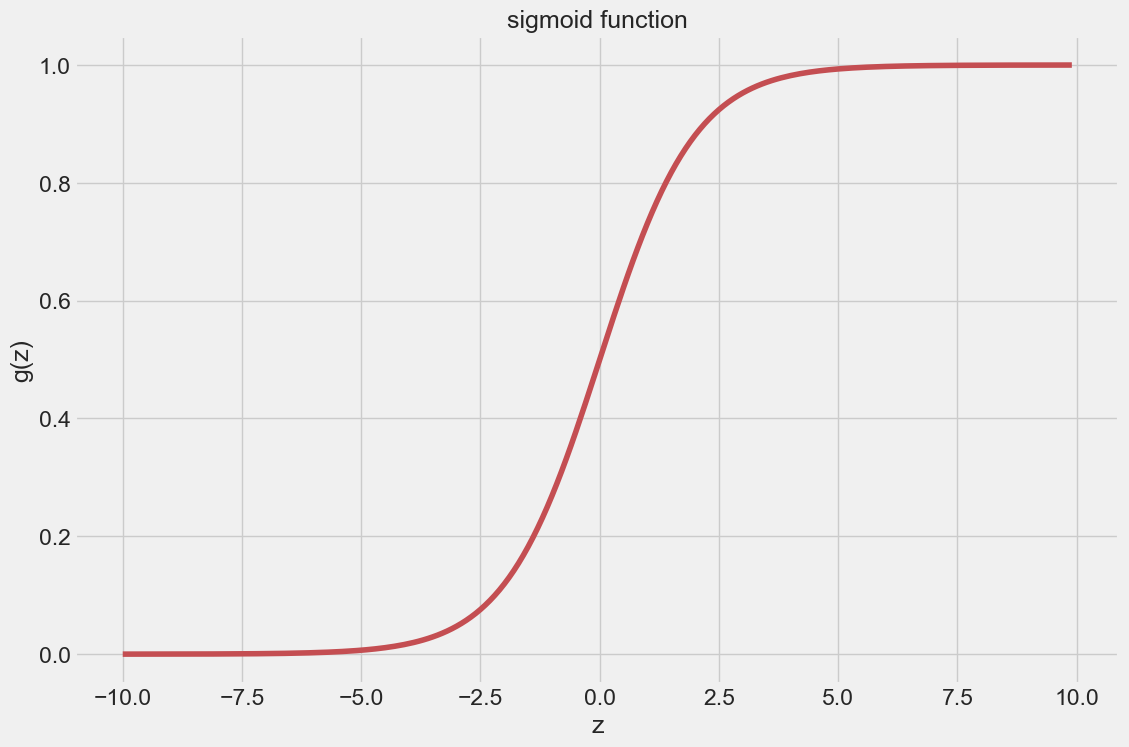

In [45]:
nums = np.arange(-10, 10, step=0.1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

## Cost Function 代价函数

棒极了！现在，我们需要编写代价函数来评估结果。
代价函数：
$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$

In [46]:
def cost(theta, X, y):
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

让我们来检查矩阵的维度来确保一切良好。

In [47]:
theta = np.zeros(3)
theta

array([0., 0., 0.])

In [48]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100,))

让我们计算初始化参数的代价函数(theta为0)。

In [49]:
cost(theta, X, y)

0.6931471805599453

看起来不错，接下来，我们需要一个函数来计算我们的训练数据、标签和一些参数thata的梯度。

## Gradient descent 梯度下降
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{\left({h_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}\right)x_{_{j}}^{(i)}}$$

In [50]:
# Gradient的实现，利用的是循环的方法
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y).T
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("theta.shape = ", theta.shape)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X @ theta.T) - y
    print("error.shape = ", error.shape)
    
    for i in range(parameters):
        term = X[:,i].T @ error
        grad[i] = term / len(X)
    
    return grad

In [51]:
# 另外一种实现的方法
def gradient(theta, X, y):
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

我们看看用我们的数据和初始参数为0的梯度下降法的结果。

In [52]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

## 拟合参数

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [53]:
import scipy.optimize as opt
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.20349770654887073
       x: [-2.516e+01  2.062e-01  2.014e-01]
     nit: 28
     jac: [ 9.173e-06  4.865e-04  4.405e-04]
    nfev: 72
    njev: 186
    nhev: 0


让我们看看在这个结论下代价函数计算结果是什么个样子~

In [54]:
cost(res.x, X, y)

0.20349770654887073

## 用训练集预测和验证

接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。
逻辑回归模型的假设函数： 
	$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}} $$
当${{h}_{\theta }}$大于等于0.5时，预测 y=1

当${{h}_{\theta }}$小于0.5时，预测 y=0 。

In [55]:
def predict(theta, X):
    probability = sigmoid(X @ theta)
    return [1 if x >= 0.5 else 0 for x in probability]

In [56]:
theta_min = res.x
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))
print(classification_report(y, predictions))

accuracy = 89%
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



我们的逻辑回归分类器预测正确，如果一个学生被录取或没有录取，达到89%的精确度。不坏！记住，这是训练集的准确性。我们没有保持住了设置或使用交叉验证得到的真实逼近，所以这个数字有可能高于其真实值（这个话题将在以后说明）。

## 寻找决策边界
决策便捷是一系列的$x$可以满足：$$\frac{1}{1+e^{-\theta^T x}}=0.5$$
也就是说$$e^{-\theta^T x} = 1$$
意味着 $$\theta^T X = 0$$

这是一条直线。

参考这里：http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier


In [57]:
print(res.x) # this is final theta

[-25.15556212   0.20618593   0.20142451]


In [58]:
# x0 = 1
# 定义x1的range后，根据 θ0 + x1*θ1 + x2*θ2 = 0，可得x2
x1 = np.arange(130, step=0.1)

coef = -(res.x / res.x[2])  # find the equation
x2 = coef[0] + coef[1]*x1

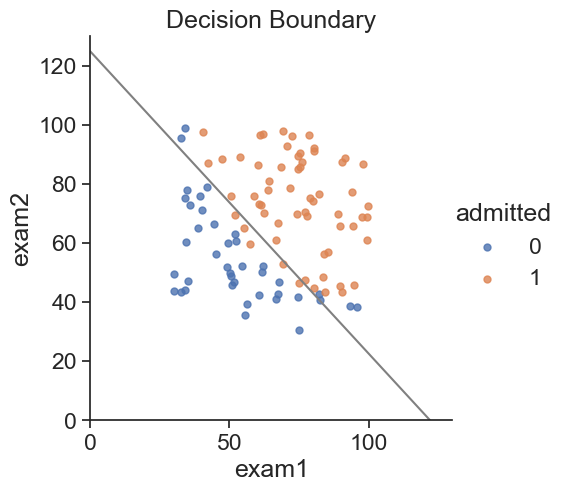

In [59]:
import seaborn as sns
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot(x ='exam1', y = 'exam2', hue='admitted', data=data, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x1, x2, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

## 正则化逻辑回归

在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。如果你对正则化有点眼生，或者喜欢这一节的方程的背景，请参考在"exercises"文件夹中的"ex2.pdf"。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

和第一部分很像，从数据可视化开始吧！

In [60]:
data2 = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
data2.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


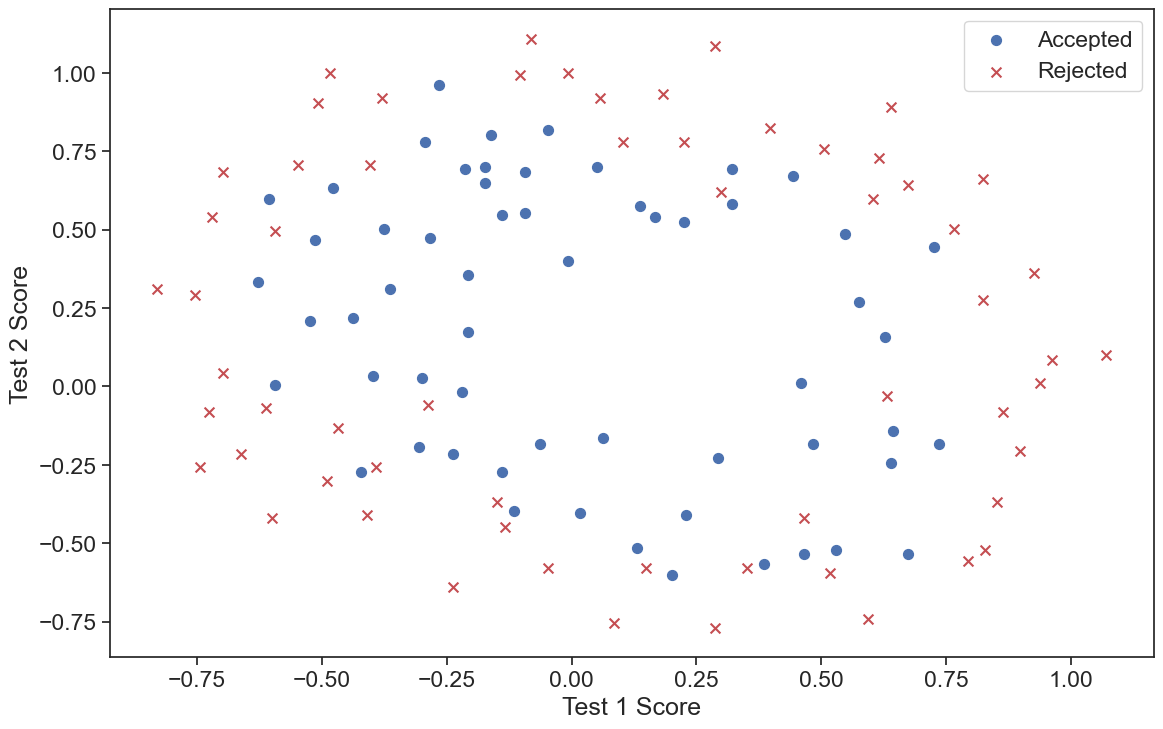

In [61]:
positive = data2[data2['accepted'].isin([1])]
negative = data2[data2['accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['test1'], positive['test2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['test1'], negative['test2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

哇，这个数据看起来可比前一次的复杂得多。特别地，你会注意到其中没有线性决策界限，来良好的分开两类数据。一个方法是用像逻辑回归这样的线性技术来构造从原始特征的多项式中得到的特征。让我们通过创建一组多项式特征入手吧。

In [62]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).values
    else:
        return pd.DataFrame(data)

In [63]:
degree = 5
x1 = np.array(data2.test1)
x2 = np.array(data2.test2)

data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是成本函数：

## Regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [64]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(data2)
print(y.shape)

(118, 28)
(118,)


In [65]:
def regularized_cost(theta, X, y, l=1):
#     '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term
#正则化代价函数

In [66]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

## Regularized gradient(正则化梯度) 

$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

请注意等式中的"reg" 项。还注意到另外的一个“学习率”参数。这是一种超参数，用来控制正则化项。现在我们需要添加正则化梯度函数：

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$


In [67]:
def regularized_gradient(theta, X, y, l=1):
#     '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

就像在第一部分中做的一样，初始化变量。

In [68]:
regularized_gradient(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

让我们初始学习率到一个合理值。，果有必要的话（即如果惩罚太强或不够强）,我们可以之后再折腾这个。

In [69]:
learningRate = 1

现在，让我们尝试调用新的默认为0的theta的正则化函数，以确保计算工作正常。

In [71]:
regularized_cost(theta, X, y, learningRate)

0.6931471805599454

现在我们可以使用和第一部分相同的优化函数来计算优化后的结果。

## 拟合参数

In [73]:
import scipy.optimize as opt

In [74]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.529002729712873
       x: [ 1.273e+00  6.253e-01 ... -1.439e-01 -9.247e-01]
     nit: 6
     jac: [-2.387e-07  9.657e-08 ...  5.014e-09 -2.276e-08]
    nfev: 8
    njev: 68
    nhev: 0

最后，我们可以使用第1部分中的预测函数来查看我们的方案在训练数据上的准确度。

## 预测

In [75]:
final_theta = res.x
y_pred = predict(final_theta, X)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



虽然我们实现了这些算法，值得注意的是，我们还可以使用高级Python库像scikit-learn来解决这个问题。

In [76]:
from sklearn import linear_model#调用sklearn的线性回归包
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X, y.ravel())

LogisticRegression()

In [77]:
model.score(X, y)

0.8305084745762712

这个准确度和我们刚刚实现的差了好多，不过请记住这个结果可以使用默认参数下计算的结果。我们可能需要做一些参数的调整来获得和我们之前结果相同的精确度。

## 使用不同的 $\lambda$ 
### 画出决策边界
* 我们找到所有满足 $X\times \theta = 0$ 的x
* instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [93]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot(x='test1', y='test2', hue='accepted', data=df, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='r', s=10)
    plt.title('Decision boundary')
    plt.show()

In [94]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

In [95]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.values @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

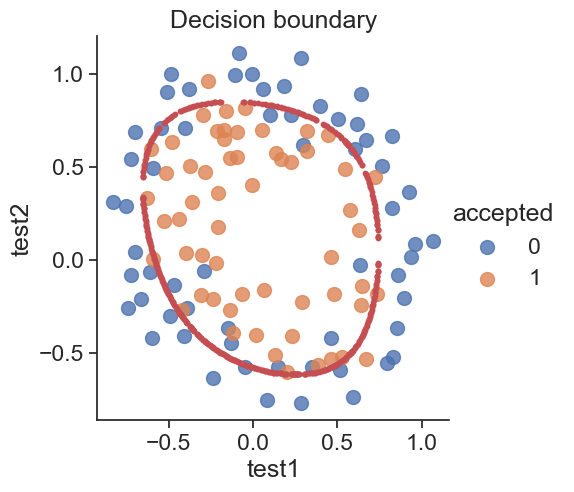

In [96]:
draw_boundary(power=6, l=1)#lambda=1

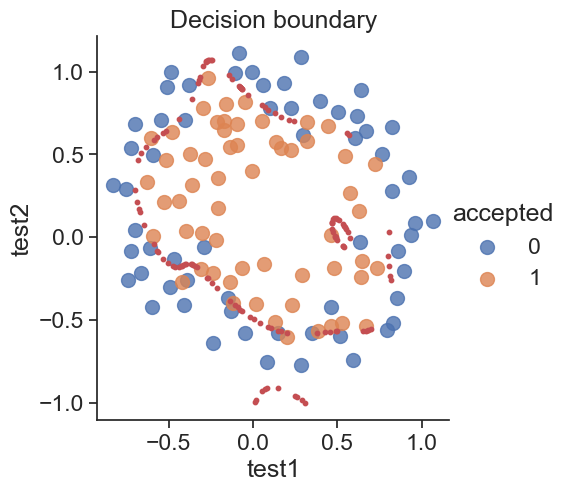

In [97]:
draw_boundary(power=6, l=0)  # no regularization, over fitting，#lambda=0,没有正则化，过拟合了

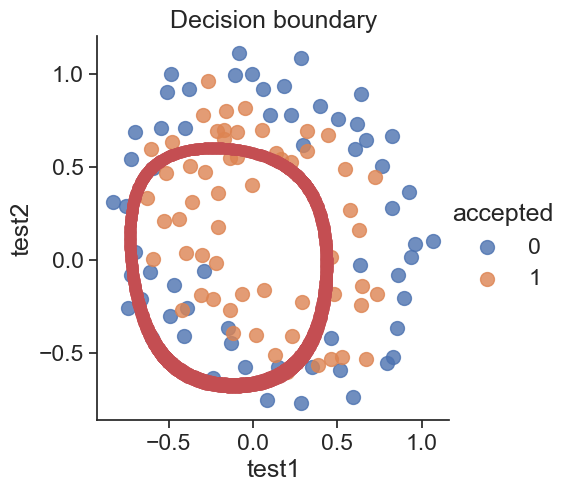

In [98]:
draw_boundary(power=6, l=100)  # underfitting，#lambda=100,欠拟合